## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3, AugTextDataset
from bert import CustomBert3, CustomBert5, CustomBert3b
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, FocalLoss
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train['question'] = train['question_title'] + ' [SEP] ' + train['question_body']
test['question'] = test['question_title'] + ' [SEP] ' + test['question_body']
train['answer'] = train['question_title'] + ' [SEP] ' + train['answer']
test['answer'] = test['question_title'] + ' [SEP] ' + test['answer']

In [4]:
# %%time
# init_seed()
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# ids_train = {}
# ids_test = {}
# num_aug = 4
# max_seq_len = 512
# for mode, df in [('train', train), ('test', test)]:
#     for text in INPUTS:
#         ids = {i: [] for i in range(num_aug+1)}
#         for x in tqdm(df[text].values):
#             if len(x.split(' ')) > 10:
#                 augs = eda(x, alpha_sr=0.05, alpha_ri=0.05, alpha_rs=0.05, p_rd=0.05, num_aug=num_aug)[:-1]
#                 augs = [x] + augs
#             else:
#                 augs = (num_aug + 1) * [x]
#             encoded_inputs = []
#             for i, aug in enumerate(augs):
#                 encoded_inputs = tokenizer.encode_plus(
#                     aug, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)['input_ids']
#                 ids[i] += [encoded_inputs]
#         if mode == 'train': ids_train[text] = [np.array(aug_ids) for aug_ids in ids.values()]
#         else: ids_test[text]  = [np.array(aug_ids) for aug_ids in ids.values()]

# for mode, ids in [('train', ids_train), ('test', ids_test)]:
#     question_ids = {i: [] for i in range(num_aug+1)}
#     for i in tqdm(range(len(ids['question_title'][0]))):
#         for j, aug in enumerate(augs):
#             qt_ids = ids['question_title'][j][i]
#             qb_ids = ids['question_body'][j][i]
#             q_ids = np.concatenate((qt_ids[qt_ids!=0], qb_ids[1:]))[:max_seq_len]
#             question_ids[j].append(q_ids)
#     if mode == 'train': ids_train['question'] = [np.array(aug_ids) for aug_ids in question_ids.values()]
#     else: ids_test['question']  = [np.array(aug_ids) for aug_ids in question_ids.values()]

In [5]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 27.1 s, sys: 214 ms, total: 27.3 s
Wall time: 27.5 s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
y = train[TARGETS].values.astype(np.float32)

In [9]:
num_workers = 10
bs = 4
TextDataset = TextDataset3

In [10]:
bs_test = 4
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [11]:
class MyRankingLoss(nn.MSELoss):
    def forward(self, input, target):
        input = torch.sigmoid(input)
        n = input.size(0)
        n_pairs = n // 2
        n_tot_pairs = n_pairs + (n % 2)
        loss = 0
        for i in range(n_pairs):
            dp = input[2*i] - input[(2*i)+1]
            dy = target[2*i] - target[(2*i)+1]
            loss += super().forward(dp, dy) / n_tot_pairs
            
        if n_tot_pairs > n_pairs:
            dp = input[-2] - input[-1]
            dy = target[-2] - target[-1]
            loss += super().forward(dp, dy) / n_tot_pairs
        return loss
    
class MixedLoss(nn.Module):
    def __init__(self, pos_weight=N_TARGETS*[1.0]):
        super().__init__()
        pos_weight = torch.Tensor(pos_weight).cuda()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
        self.mrl = MyRankingLoss()

    def forward(self, input, target):
        loss = (1. * self.bce(input, target) + 1. * self.mrl(input, target))
        return loss.mean()

In [12]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 2
weight_decay = 0.01
model_name = 'double_distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None
p_aug = 0.0

In [13]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Tue Jan  7 23:38:07 2020
CustomBert3(
  (q_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn):

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


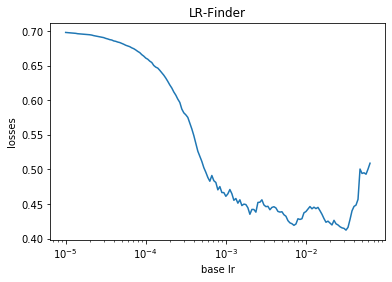

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42573 - spearmanr 0.19572
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38383 - spearmanr 0.35621
best model: epoch 0 - 0.35621
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.36972 - spearmanr 0.37174
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37004 - spearmanr 0.39748


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 1 - 0.39748
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35404 - spearmanr 0.4408
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36864 - spearmanr 0.42106
best model: epoch 2 - 0.42106
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.3419 - spearmanr 0.49515
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36913 - spearmanr 0.42472
best model: epoch 3 - 0.42472
TRAINING END: Best score achieved on epoch 3 - 0.42472
Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Fold 2 started at Tue Jan  7 23:57:11 2020
epoch 0: 	 Start training...


In [ ]:
init_seed()
folds = GroupKFold(n_splits=5).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'], train_index, #p_aug=p_aug,
                       targets=y), batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, #p_aug=0.0, 
                       targets=y), batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / 5
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4160

In [ ]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

from scipy.stats import spearmanr
def spearmanr_np(preds, targets):
    score = 0
    for i in range(N_TARGETS):
        score_i = spearmanr(preds[:, i], targets[:, i]).correlation
        score += np.nan_to_num(score_i / N_TARGETS)
    return score

In [ ]:
spearmanr_np(oofs, y)

In [ ]:
spearmanr_np(round_preds(oofs, high_num=3), y)

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()